# Merging Tile Label Masks
Merging polygons of adjacent tiles if the boundaries meet and are of same class.

In [42]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np
import cv2 as cv
from geopandas import GeoDataFrame
from tqdm.notebook import tqdm

from dsa_helpers import imread
from dsa_helpers.girder_utils import login

from shapely.geometry import Polygon
from shapely.affinity import translate

In [2]:
def mask_to_geojson(
    mask_fp: str, x_offset: int = 0, y_offset: int = 0, 
    background_label: int = 0, min_area: int = 0
) -> list[Polygon, int]:
    """
    Extract contours from a label mask and convert them into shapely 
    polygons.
    
    Args:
        mask_fp (str): Path to the mask image.
        x_offset (int): Offset to add to x coordinates of polygons.
        y_offset (int): Offset to add to y coordinates of polygons.
        background_label (int): Label value of the background class, 
            which is ignored.
    
    Returns:
        list[Polygon, int]: List of polygons and their corresponding 
            labels.
            
    """
    # Read label mask from file.
    mask = imread(mask_fp, grayscale=True)
    
    # Find unique labels (excluding background 0)
    labels = [label for label in np.unique(mask) if label != background_label]
    
    polygons = []  # Track all polygons.
        
    # Loop through unique label index.
    for label in labels:
        # Filter to mask for this label.
        label_mask = (mask == label).astype(np.uint8)
        
        # Find contours.
        contours, hierarchy = cv.findContours(
            label_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE
        )
        
        # Process the contours.
        polygons_dict = {}

        for idx, (contour, h) in enumerate(zip(contours, hierarchy[0])):
            if len(contour) > 3:
                if idx not in polygons_dict:
                    polygons_dict[idx] = {"holes": []}
                
                if h[3] == -1:
                    polygons_dict[idx]["polygon"] = contour.reshape(-1, 2)
                else:
                    polygons_dict[h[3]]["holes"].append(contour.reshape(-1, 2))
        
        # Now that we know the polygon and the holes, create a Polygon object for each.
        for data in polygons_dict.values():   
            if 'polygon' in data: 
                polygon = Polygon(data["polygon"], holes=data["holes"])
                
                # Shift the polygon by the offset.
                polygon = translate(polygon, xoff=x_offset, yoff=y_offset)
                            
                # Skip small polygons.
                if polygon.area >= min_area:
                    polygons.append([polygon, label])
        
    return polygons

In [39]:
# Constants
TILES_DIR = "~/data/uk-tiles-20x-512/"
SF = 20 / 40  # tile mag to scan magnification

idx2label = {
    1: "Gray Matter",
    2: "White Matter",
    3: "Superficial",
    4: "Leptomeninges"
}

LINE_COLORS = {
    1: "rgb(0,128,0)",
    2: "rgb(0,0,255)",
    3: "rgb(255,255,0)",
    4: "rgb(0,0,0)"
}

FILL_COLORS = {
    1: "rgba(0,128,0,0.5)",
    2: "rgba(0,0,255,0.5)",
    3: "rgba(255,255,0,0.5)",
    4: "rgba(0,0,0,0.5)"
}

In [4]:
tiles_dir = Path(TILES_DIR)
tiles_df = pd.read_csv(tiles_dir / "tile_metadata.csv")

# Update the x & y coordinates to tile magnification.
for idx, row in tiles_df.iterrows():
    tiles_df.at[idx, "x"] = int(row["x"] * SF)
    tiles_df.at[idx, "y"] = int(row["y"] * SF)
tiles_df.head()

,fp,x,y,mask_fp,wsi_name,mag,tile_size
0,/home/jvizcar/data/uk-tiles-20x-512/images/dei...,0,0,/home/jvizcar/data/uk-tiles-20x-512/masks/deid...,deident_0357e4d4-541a-11ef-b9af-0242ac110002.svs,20.0,512
1,/home/jvizcar/data/uk-tiles-20x-512/images/dei...,0,512,/home/jvizcar/data/uk-tiles-20x-512/masks/deid...,deident_0357e4d4-541a-11ef-b9af-0242ac110002.svs,20.0,512
2,/home/jvizcar/data/uk-tiles-20x-512/images/dei...,0,1024,/home/jvizcar/data/uk-tiles-20x-512/masks/deid...,deident_0357e4d4-541a-11ef-b9af-0242ac110002.svs,20.0,512
3,/home/jvizcar/data/uk-tiles-20x-512/images/dei...,0,1536,/home/jvizcar/data/uk-tiles-20x-512/masks/deid...,deident_0357e4d4-541a-11ef-b9af-0242ac110002.svs,20.0,512
4,/home/jvizcar/data/uk-tiles-20x-512/images/dei...,0,2048,/home/jvizcar/data/uk-tiles-20x-512/masks/deid...,deident_0357e4d4-541a-11ef-b9af-0242ac110002.svs,20.0,512


In [5]:
# Filter to one WSI.
unique_wsi_names = list(tiles_df['wsi_name'].unique())

tiles_df = tiles_df[tiles_df['wsi_name'] == unique_wsi_names[0]]
print(f"Total number of tiles: {len(tiles_df)}")
tiles_df.head()

Total number of tiles: 7802


,fp,x,y,mask_fp,wsi_name,mag,tile_size
0,/home/jvizcar/data/uk-tiles-20x-512/images/dei...,0,0,/home/jvizcar/data/uk-tiles-20x-512/masks/deid...,deident_0357e4d4-541a-11ef-b9af-0242ac110002.svs,20.0,512
1,/home/jvizcar/data/uk-tiles-20x-512/images/dei...,0,512,/home/jvizcar/data/uk-tiles-20x-512/masks/deid...,deident_0357e4d4-541a-11ef-b9af-0242ac110002.svs,20.0,512
2,/home/jvizcar/data/uk-tiles-20x-512/images/dei...,0,1024,/home/jvizcar/data/uk-tiles-20x-512/masks/deid...,deident_0357e4d4-541a-11ef-b9af-0242ac110002.svs,20.0,512
3,/home/jvizcar/data/uk-tiles-20x-512/images/dei...,0,1536,/home/jvizcar/data/uk-tiles-20x-512/masks/deid...,deident_0357e4d4-541a-11ef-b9af-0242ac110002.svs,20.0,512
4,/home/jvizcar/data/uk-tiles-20x-512/images/dei...,0,2048,/home/jvizcar/data/uk-tiles-20x-512/masks/deid...,deident_0357e4d4-541a-11ef-b9af-0242ac110002.svs,20.0,512


  0%|          | 0/7802 [00:00<?, ?it/s]

<Axes: >

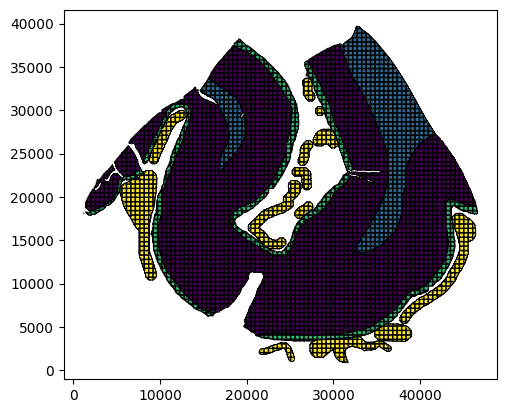

In [57]:
polygons_with_labels = []

tqdm.pandas()

# Function to process each row and return polygons with labels
def process_row(row):
    result = mask_to_geojson(
        row["mask_fp"], x_offset=row["x"], y_offset=row["y"]
    )
    
    return result if len(result) else None
    
    
# Apply the function to all rows and flatten the results
polygons_with_labels = tiles_df.progress_apply(
    lambda row: process_row(row), axis=1
).explode().dropna().tolist()  # Explode lists of polygons from each row
         
gdf = GeoDataFrame(polygons_with_labels, columns=["geometry", "label"])

# Apply a buffer to make edges touch.
gdf["geometry"] = gdf["geometry"].buffer(1)

gdf.plot(edgecolor="black", column="label")

<Axes: >

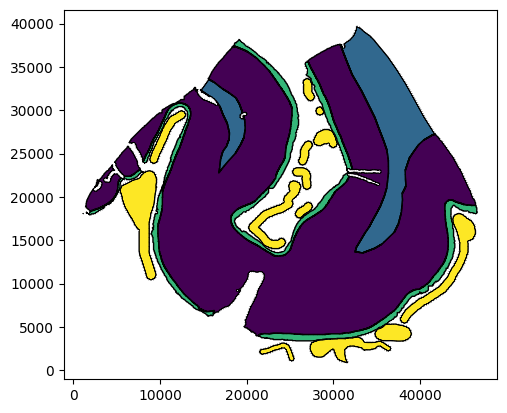

In [58]:
# Dissolve the dataframe by the label.
gdf_dissolved = gdf.dissolve(by="label", as_index=False)

# Apply the buffer to the dissolved dataframe.
gdf_dissolved["geometry"] = gdf_dissolved["geometry"].buffer(-1)
gdf_dissolved.plot(edgecolor="black", column="label")

In [71]:
# Format the multipolygons into DSA annotation format.
elements = []
tolerance = 0.5

for idx, row in gdf_dissolved.iterrows():
    list_of_polygons = list(row['geometry'].geoms)
    label = row['label']
    
    for poly in list_of_polygons:
        exterior_poly = list(poly.exterior.coords)
        interior_polys = [list(interior.coords) for interior in poly.interiors]
        
        if len(exterior_poly) > 1000:
            poly = poly.simplify(tolerance, preserve_topology=True)
            exterior_poly = list(poly.exterior.coords)
        
        points = [
            [int(xy[0]) * 2, int(xy[1]) * 2, 0] for xy in exterior_poly
        ]
        
        holes = []
        
        for interior_poly in interior_polys:
            hole = [
                [int(xy[0]) * 2, int(xy[1]) * 2, 0] for xy in interior_poly
            ]
            holes.append(hole)

        element = {
                "points": points,
                "fillColor": FILL_COLORS[label],
                "lineColor": LINE_COLORS[label],
                "type": "polyline",
                "lineWidth": 2,
                "closed": True,
                "label": {"value": idx2label[label]},
                "group": "Gray White Segmentation"
        }
        
        if len(holes):
            element["holes"] = holes
            
        elements.append(element)

In [43]:
gc = login("http://bdsa.pathology.emory.edu:8080/api/v1")

In [72]:
_ = gc.post(
    '/annotation?itemId=673b58d3900c0c0559bf1b76', 
    json={
        'name': "temp", 
        'description': '', 
        'elements': elements
    }
)